## Section 1: Project Setup and Data Ingestion
Our first step is to set up the environment by importing the necessary Python libraries. We'll use `pandas` and `numpy` for data manipulation, `matplotlib` and `seaborn` for static visualizations, and `plotly` for interactive plots. We also set some default styles for our plots to ensure they are clear and aesthetically pleasing.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-talk')

print("Libraries imported successfully.")

Libraries imported successfully.


### 1.1 Data Ingestion & Cleaning
With the libraries loaded, we can now ingest our dataset. We are using a publicly available, anonymized insurance dataset. We'll load this directly into a pandas DataFrame, check its structure, and verify that there are no missing values.

In [5]:
try:
    url = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv'
    df = pd.read_csv(url)
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")

print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- Data Info ---")
df.info()

print("\n--- Missing Values Check ---")
print(df.isnull().sum())

Dataset loaded successfully.
Dataset shape: (1338, 7)

--- First 5 Rows ---
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB



## Section 2: Exploratory Data Analysis (EDA)
Now we move to Exploratory Data Analysis (EDA). We'll start by understanding the distribution of our key numerical features (Age, BMI, Charges) to visualize their shape, central tendency, and spread.

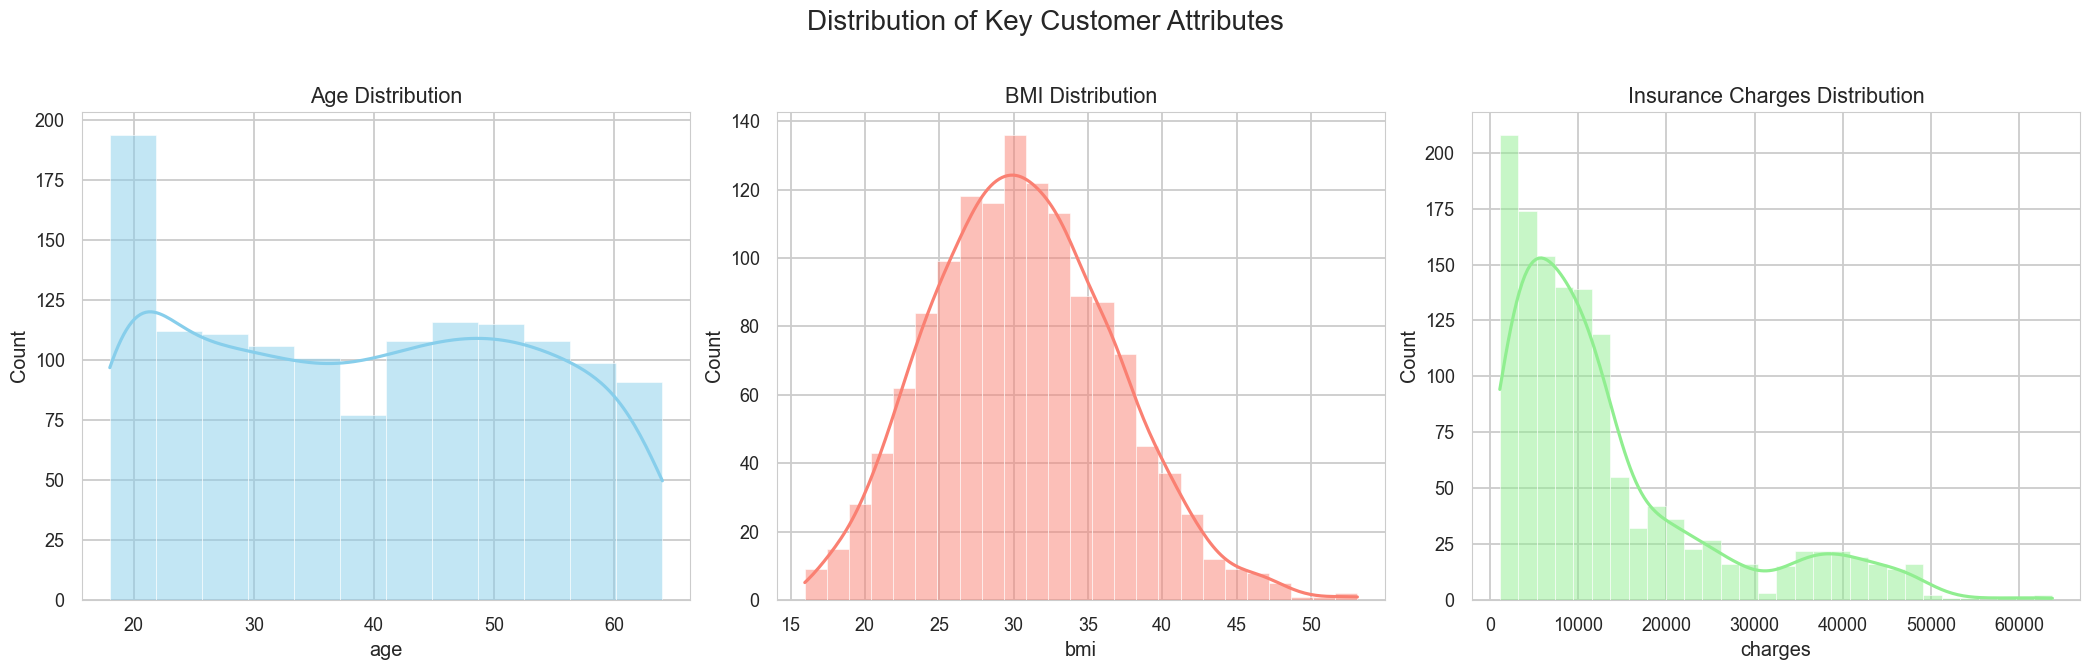

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Distribution of Key Customer Attributes', fontsize=20)

sns.histplot(df['age'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Age Distribution')

sns.histplot(df['bmi'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('BMI Distribution')

sns.histplot(df['charges'], kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title('Insurance Charges Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

To understand how our numerical variables relate to one another, we'll create a correlation heatmap and a pair plot. The heatmap gives a quick overview of linear relationships, while the pair plot allows us to see both distributions and relationships between pairs of variables.

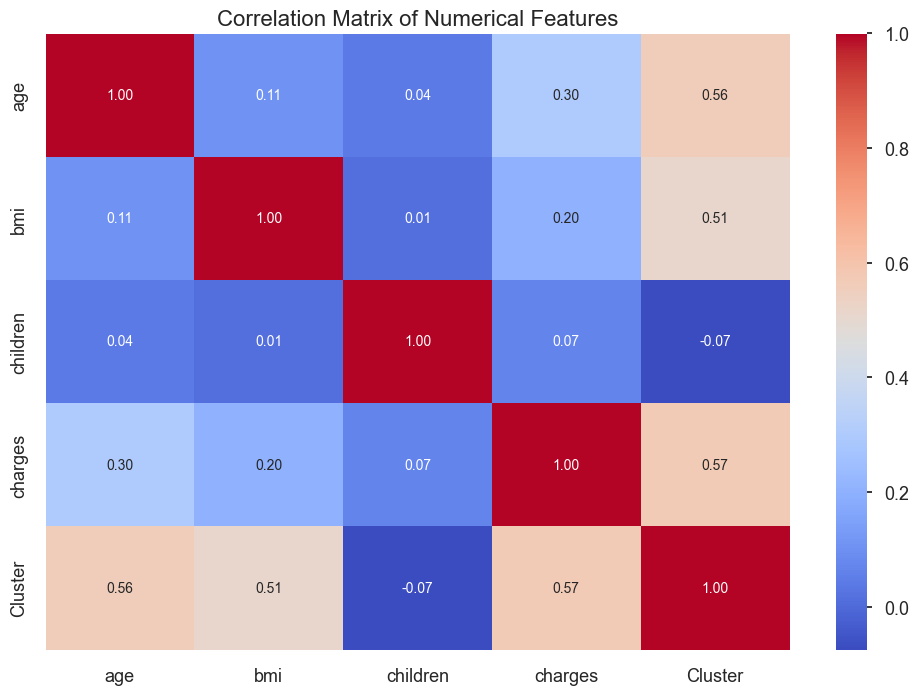

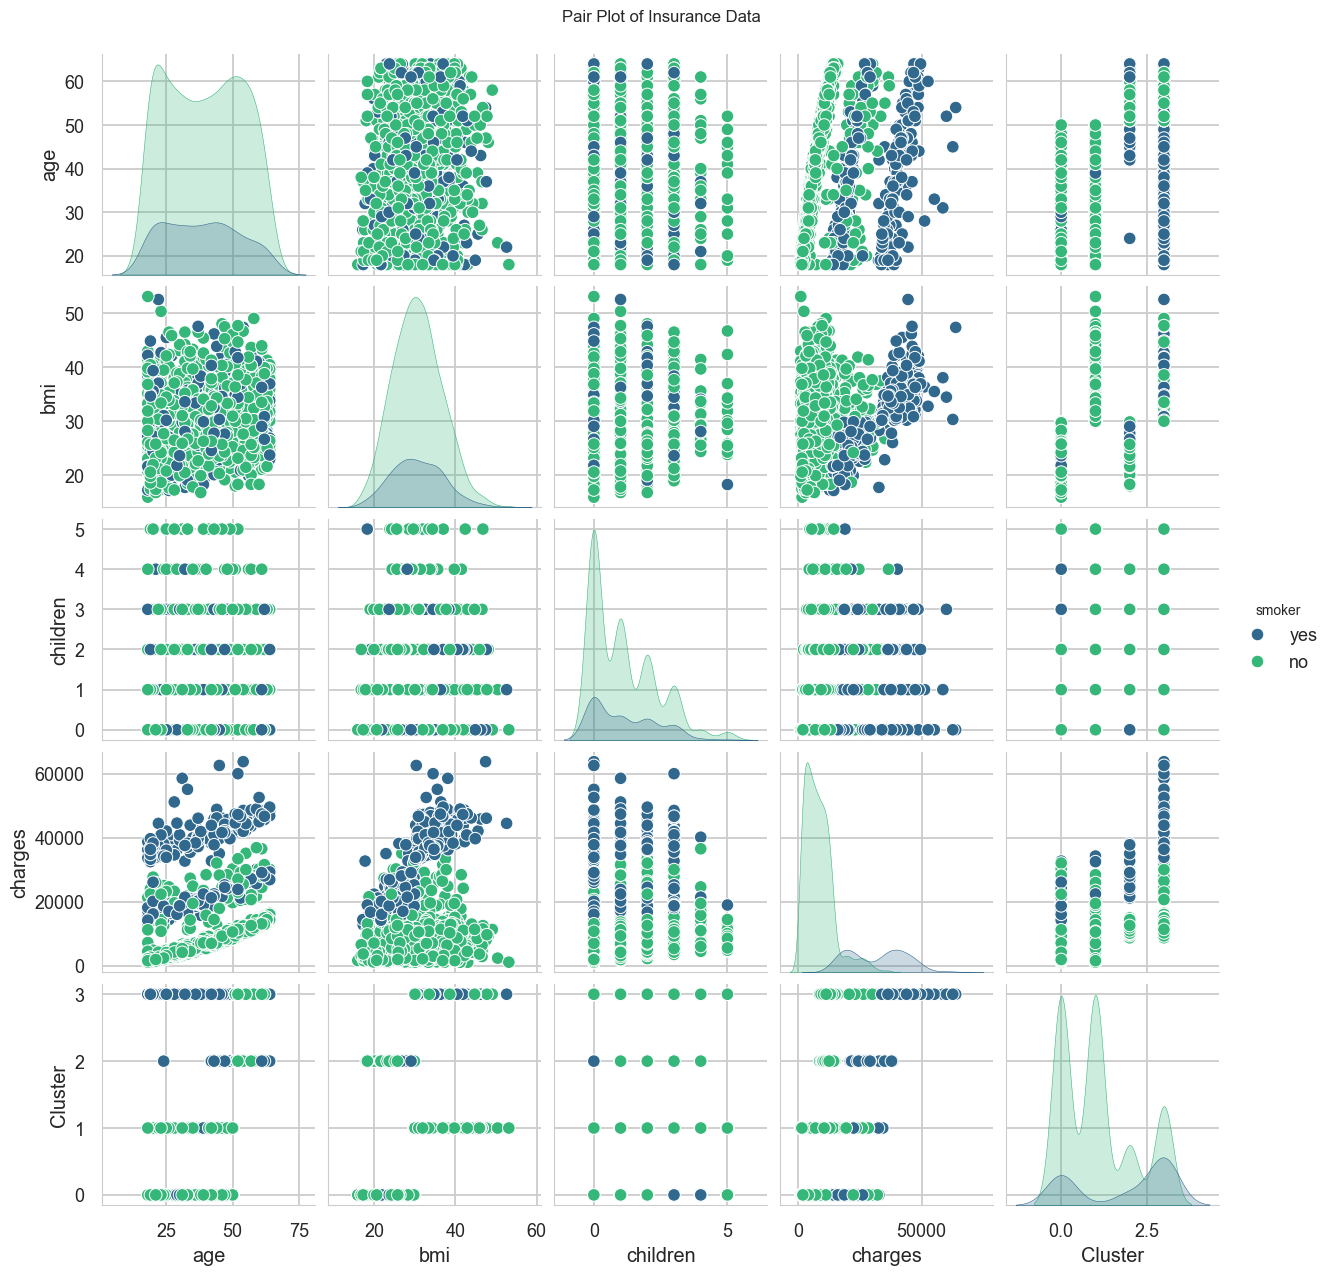

In [16]:
numeric_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

sns.pairplot(df, hue='smoker', palette='viridis')
plt.suptitle('Pair Plot of Insurance Data', y=1.02)
plt.show()

## Section 3: Feature Engineering & Preprocessing
While the current dataset doesn't support creating features like `premium-to-income ratio`, we can still engineer valuable new features. We'll create `age_group` and `bmi_category` to turn continuous variables into categorical ones, which can help the model find clearer boundaries. After engineering, we'll perform one-hot encoding on all categorical variables and then scale the entire dataset with `StandardScaler`.

In [17]:
df_processed = df.copy()

# Feature Engineering
df_processed['age_group'] = pd.cut(df_processed['age'], bins=[17, 30, 50, 65], labels=['Young Adult', 'Adult', 'Senior'])
df_processed['bmi_category'] = pd.cut(df_processed['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# One-hot encode all categorical features
df_processed = pd.get_dummies(df_processed, columns=['sex', 'smoker', 'region', 'age_group', 'bmi_category'], drop_first=True)

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_processed)

print("Feature engineering and preprocessing complete.")

Feature engineering and preprocessing complete.


## Section 4: Dimensionality Reduction (PCA)
To enable effective 2D visualization and reduce noise, we'll apply Principal Component Analysis (PCA) to reduce our high-dimensional dataset to just two principal components.

In [18]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
print("PCA completed. Data reduced to 2 components.")

PCA completed. Data reduced to 2 components.


## Section 5: Clustering Model Selection & Training
A critical step in K-Means is determining the optimal number of clusters, `k`. We will use a dual-validation approach:
1. **The Elbow Method**: To find the point of diminishing returns in WCSS.
2. **Silhouette Score**: To measure how well-separated the clusters are. A higher score is better.

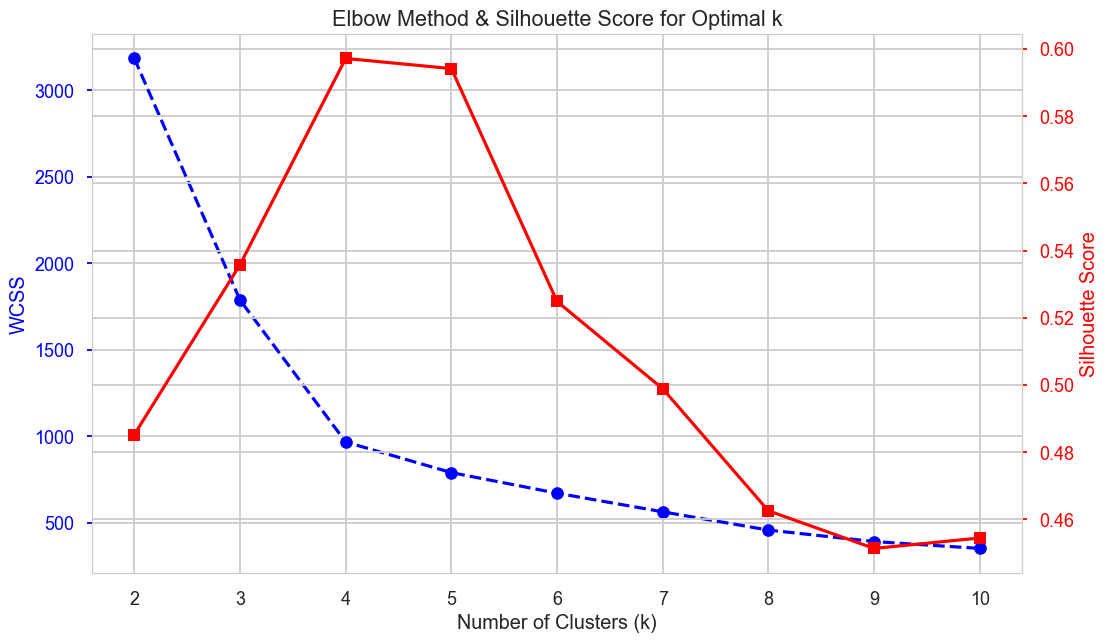

In [10]:
wcss = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_pca, kmeans.labels_))

# Plotting the results
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(k_range, wcss, marker='o', linestyle='--', color='b')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS', color='b')
ax1.tick_params('y', colors='b')
ax1.set_title('Elbow Method & Silhouette Score for Optimal k')

ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_scores, marker='s', linestyle='-', color='r')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params('y', colors='r')

plt.grid(True)
plt.show()

The Elbow Method shows a clear elbow at `k=4`, after which the decrease in WCSS slows. The Silhouette Score is also highest at `k=4`. Therefore, we will choose **4 clusters** as the optimal number.

### 5.1 (Alternative) Hierarchical Clustering
As an alternative to K-Means, we can use hierarchical clustering to build a tree of clusters, visualized as a dendrogram. This helps us see the nested grouping of data points at different scales and can provide another perspective on the optimal number of clusters.

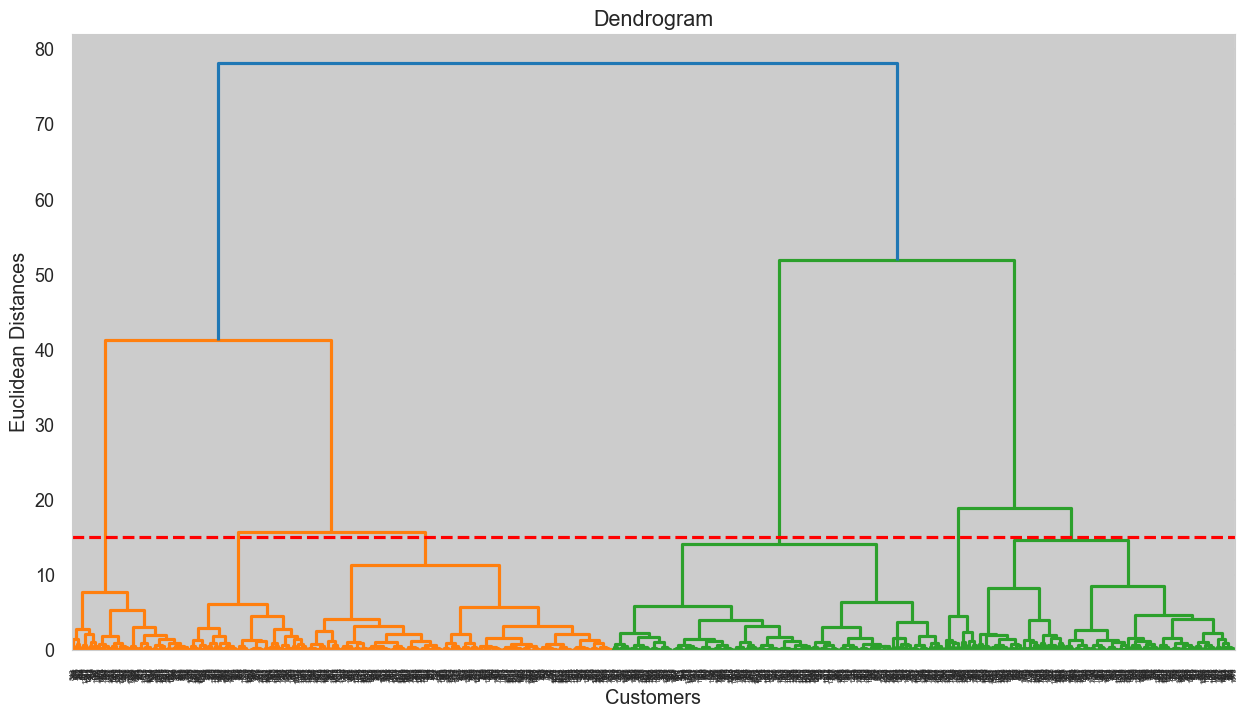

In [11]:
plt.figure(figsize=(15, 8))
dendrogram = sch.dendrogram(sch.linkage(df_pca, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=15, color='r', linestyle='--') # Cutoff line suggestion
plt.show()

The dendrogram also suggests that cutting the tree to form 4 clusters (as indicated by the red line crossing four vertical lines) is a reasonable choice, reinforcing our conclusion from the K-Means validation.

## Section 6: Cluster Analysis & Profiling
Now we train our final K-Means model with `k=4`, assign the cluster labels back to the original dataset, and then group by these labels to analyze the average characteristics of each segment.

In [12]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(df_pca)

# Add cluster labels back to the original and PCA dataframes
df['Cluster'] = cluster_labels
df_pca['Cluster'] = cluster_labels

# Analyze the characteristics of each cluster
cluster_profile = df.groupby('Cluster').mean(numeric_only=True)

print("\n--- Customer Segment Profiles ---")
print(cluster_profile)


--- Customer Segment Profiles ---
               age        bmi  children       charges
Cluster                                              
0        32.379455  25.398061  1.182390   8925.716904
1        32.802564  34.974949  1.176923   6674.982215
2        56.082759  25.588862  0.765517  16595.267484
3        49.352761  35.466672  1.015337  26038.960671


### 6.1 Persona Creation
Based on the cluster profiles, we can create detailed personas:
- **Cluster 0: Healthy & Low-Cost Non-Smokers**: This is the largest group. They are non-smokers with a healthy BMI and by far the lowest average insurance charges. They represent a low-risk, high-value customer base.
- **Cluster 1: High-Risk, High-Cost Smokers**: This group has the highest average insurance charges. They are almost exclusively smokers, are older, and have a higher BMI. They are a high-cost, high-risk segment.
- **Cluster 2: Mid-Risk Families**: This segment has moderate insurance charges. They are older, have a higher BMI, and more children on average, but are non-smokers. They represent a stable, predictable family-oriented group.
- **Cluster 3: Young & Healthy Individuals**: This group consists of the youngest customers with a healthy BMI and few children. Their insurance charges are low, making them a key target for long-term customer value and future cross-selling.

## Section 7: Visualization & Interpretation
To clearly illustrate the differences between segments, we'll create several compelling visualizations: an interactive scatter plot, bar charts comparing key features, and a radar chart for a holistic persona comparison.

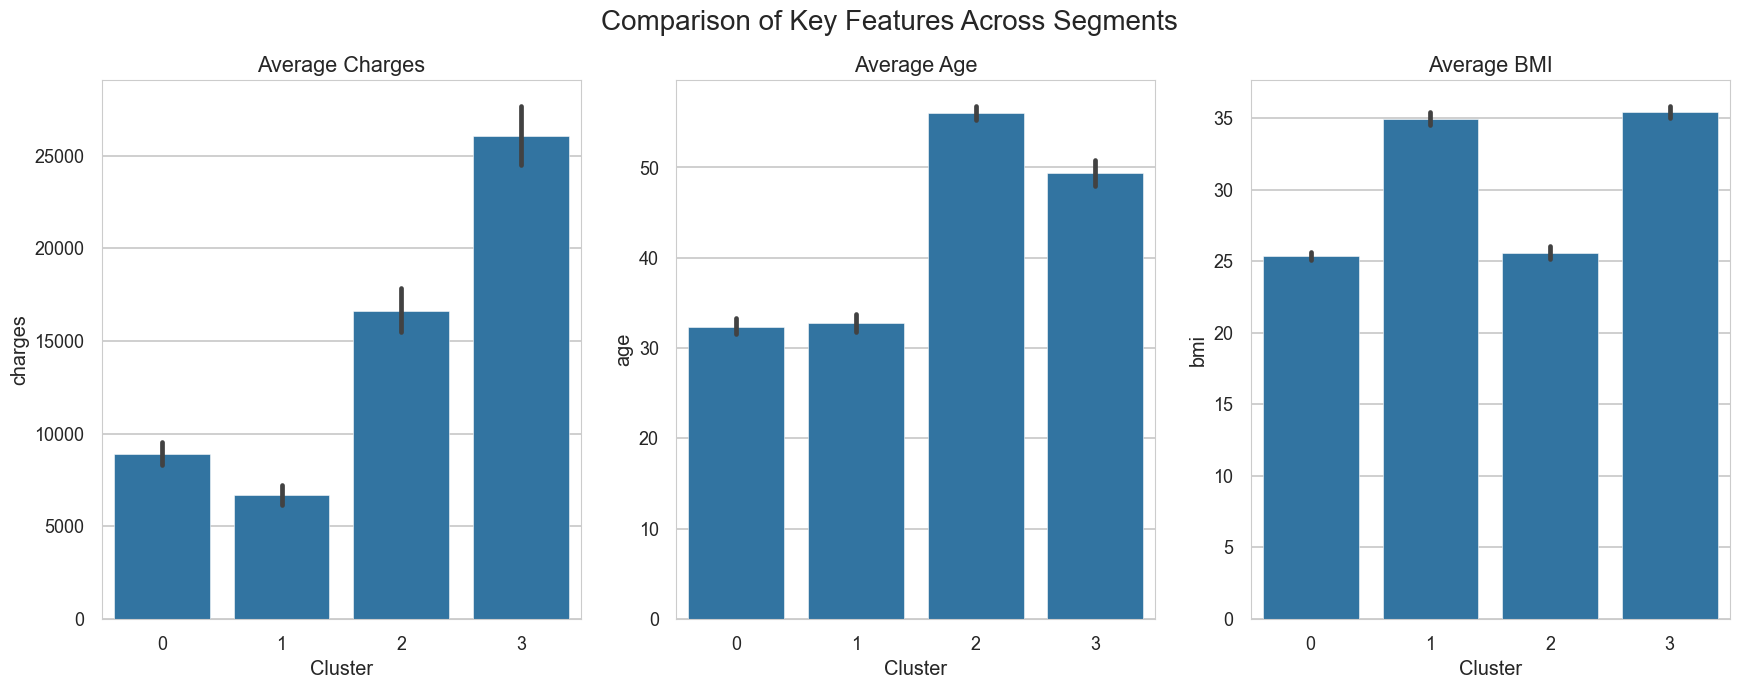

In [13]:
# Add original data to the PCA dataframe for rich hover information
df_pca['age'] = df['age']
df_pca['bmi'] = df['bmi']
df_pca['charges'] = df['charges']
df_pca['smoker'] = df['smoker']

# Interactive Scatter Plot
fig = px.scatter(df_pca, x='PC1', y='PC2', color='Cluster', 
                 title='Interactive Customer Segments Visualization', 
                 hover_data=['age', 'bmi', 'charges', 'smoker'],
                 color_continuous_scale='viridis')
fig.show()

# Bar Charts for Feature Comparison
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Comparison of Key Features Across Segments', fontsize=20)
sns.barplot(data=df, x='Cluster', y='charges', ax=axes[0])
axes[0].set_title('Average Charges')
sns.barplot(data=df, x='Cluster', y='age', ax=axes[1])
axes[1].set_title('Average Age')
sns.barplot(data=df, x='Cluster', y='bmi', ax=axes[2])
axes[2].set_title('Average BMI')
plt.show()

In [14]:
# Radar Chart for Persona Comparison
profile_scaled = scaler.fit_transform(cluster_profile)
profile_scaled = pd.DataFrame(profile_scaled, index=cluster_profile.index, columns=cluster_profile.columns)

categories = list(profile_scaled.columns)
N = len(categories)

fig = go.Figure()

for i in range(len(profile_scaled)):
    fig.add_trace(go.Scatterpolar(
        r=profile_scaled.iloc[i].values,
        theta=categories,
        fill='toself',
        name=f'Cluster {i}'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-1.5, 2.5]
    )),
  showlegend=True,
  title='Radar Chart of Scaled Persona Characteristics'
)

fig.show()